### Praktikum 1

#### Nama: Azis Ilham Kurniawan

#### NIM: 2141720145

#### Kelas: TI - 3F

In [1]:
import numpy as np # Membantu dalam manipulasi data numerik, seperti array, matriks, dan operasi matematika
import tensorflow_datasets as tfds # Menyediakan berbagai dataset yang siap digunakan
import tensorflow as tf # Menyediakan berbagai fungsi dan kelas untuk membangun, melatih, dan menjalankan model machine learning

tfds.disable_progress_bar() # Menonaktifkan progress bar dari TensorFlow Datasets

In [2]:
import matplotlib.pyplot as plt # Berguna dalam memvisualisasikan data

def plot_graphs(history, metric):
    plt.plot(history.history[metric]) # Menampilkan kurva loss atau akurasi model
    plt.plot(history.history['val_'+metric], '') # Menampilkan  kurva loss atau akurasi validasi
    plt.xlabel("Epochs") # Memberi label pada sisi horizontal
    plt.ylabel(metric) # Memberi label pada sisi vertikal
    plt.legend([metric, 'val_'+metric]) # Menambahkan daftar label

Setup input pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True) # Memuat data supervised dengan dataset berupa imdb_review
train_dataset, test_dataset = dataset['train'], dataset['test'] # Membagi dataset menjadi data uji dan data latih

train_dataset.element_spec # Mendapatkan struktur data dari elemen-elemen dalam dataset

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1): # Perulangan berdasarkan pembagian train_dataset.take(1) menjadi example dan label
    print('text: ', example.numpy()) # Menampilkan data contoh teks
    print('label: ', label.numpy()) # Menampilkan label

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000 # Inisialisasi variabel BUFFER_SIZE
BATCH_SIZE = 64 # Inisialisasi variabel BATCH_SIZE

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Mempersiapkan train_dataset dengan melakukan pengacakan dan mengatur batch untuk mencegah overfitting serta prefetch untuk mengurangi waktu memuat data
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Mempersiapkan test_dataset dengan melakukan pengacakan dan mengatur batch untuk mencegah overfitting serta prefetch untuk mengurangi waktu memuat data

for example, label in train_dataset.take(1): # Perulangan berdasarkan pembagian train_dataset.take(1) menjadi example dan label
    print('texts: ', example.numpy()[:3]) # Menampilkan 3 data contoh teks
    print()
    print('labels: ', label.numpy()[:3]) # Menampilkan 3 label

texts:  [b"Please see also my comment on Die Nibelungen part 1: Siegfried.<br /><br />The second part of UFA studio's gargantuan production of the Nibelungen saga continues in the stylised, symphonic and emotionally detached manner of its predecessor. However, whereas part one was a passionless portrayal of individual acts of heroism, part two is a chaotic depiction of bloodletting on a grand scale.<br /><br />As in part one, director Fritz Lang maintains a continuous dynamic rhythm, with the pace of the action and the complexity of the shot composition rising and falling smoothly as the tone of each scene demands. These pictures should only be watched with the note-perfect Gottfried Huppertz score, which fortunately is on the Kino DVD. Now, with this focus on mass action, Lang is presented with greater challenges in staging. The action sequences in his earliest features were often badly constructed, but now he simply makes them part of that rhythmic flow, with the level of activity on

In [6]:
VOCAB_SIZE = 1000 # Inisialisasi variabel VOCAB_SIZE
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Mengubah text menjadi nilai numerik dengan maksimal token sebanyak VOCAB_SIZE
encoder.adapt(train_dataset.map(lambda text, label: text)) # Menyesuaikan encoder dengan train_dataset

In [7]:
vocab = np.array(encoder.get_vocabulary()) # Memperoleh vocabulary yang telah dipelajari encoder dari train_dataset
vocab[:20] # Menampilkan 20 data variabel vocab

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy() # Merubah data teks menjadi numerik dengan encoder dan mengambil 3 data
encoded_example # Menampilkan array encoded_example

array([[583,  68,  79, ...,   0,   0,   0],
       [ 11,  38, 483, ...,   0,   0,   0],
       [101,   1,   1, ...,   0,   0,   0]])

In [9]:
for n in range(3): # Melakukan 3 kali perulangan
    print("Original: ", example[n].numpy()) # Menampilkan nilai example pada indeks n
    print("Round-trip: ", " ".join(vocab[encoded_example[n]])) # Menampilkan data list encode_example pada indeks n yang sudah digabungkan
    print()

# UNK => Unknown

Original:  b"Please see also my comment on Die Nibelungen part 1: Siegfried.<br /><br />The second part of UFA studio's gargantuan production of the Nibelungen saga continues in the stylised, symphonic and emotionally detached manner of its predecessor. However, whereas part one was a passionless portrayal of individual acts of heroism, part two is a chaotic depiction of bloodletting on a grand scale.<br /><br />As in part one, director Fritz Lang maintains a continuous dynamic rhythm, with the pace of the action and the complexity of the shot composition rising and falling smoothly as the tone of each scene demands. These pictures should only be watched with the note-perfect Gottfried Huppertz score, which fortunately is on the Kino DVD. Now, with this focus on mass action, Lang is presented with greater challenges in staging. The action sequences in his earliest features were often badly constructed, but now he simply makes them part of that rhythmic flow, with the level of activity 

Membuat Model

In [10]:
model = tf.keras.Sequential([ # Membual model Sequential
    encoder, # Variabel encoder sebelumnya sebagai parameter
    tf.keras.layers.Embedding( # Membuat embeded layer
        input_dim=len(encoder.get_vocabulary()), # Jumlah token dalam vocabulary
        output_dim=64, # Banyak fitur yang mewakili token
        mask_zero=True), # Mengabaikan token dengan indeks 0
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # Membuat layer bidirectional dengan layer LTSM 64 unit
    tf.keras.layers.Dense(64, activation='relu'), # Menambhakan layer Dense (Fully-Connected) dengan 64 neuron dan fungsi aktivasi berupa ReLU
    tf.keras.layers.Dense(1) # Menambhakan layer Dense (Fully-Connected) dengan 1 neuron
])

In [11]:
print([layer.supports_masking for layer in model.layers]) # Menampilkan daftar boolean apakah model mendukung masking

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.') # Inisialisasi variabel sample_text
predictions = model.predict(np.array([sample_text])) # Melakukan prediksi nilai berdasarkan sample_text yang dirubah ke array numpy
print(predictions[0]) # Menampilkan nilai prediksi pertama

1/1 [==============================] - 3s 3s/step
[-0.00677277]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000 # Membuat variabel padding
predictions = model.predict(np.array([sample_text, padding])) # Melakukan prediksi nilai berdasarkan sample_text dan padding yang dirubah ke array numpy
print(predictions[0]) # Menampilkan nilai prediksi pertama

1/1 [==============================] - 0s 353ms/step
[-0.00677277]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Compile Model dengan argument loss berdasarkan BinaryCrossentropy dengan output logits (nilai numerik yang mewakili kemungkinan kelas 1 dan 0)
              optimizer=tf.keras.optimizers.Adam(1e-4), # Menggunakan optimizer ADAM dengan learning rate 1e-4
              metrics=['accuracy']) # Dan argument metrics dengan accuracy

Training Model

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30) # Melatih model dengan train_dataset dan 10 epoch serta 30 sampel validasi

Epoch 1/10
391/391 [==============================] - 738s 2s/step - loss: 0.6468 - accuracy: 0.5714 - val_loss: 0.5061 - val_accuracy: 0.7318
Epoch 2/10
391/391 [==============================] - 758s 2s/step - loss: 0.4086 - accuracy: 0.8090 - val_loss: 0.3658 - val_accuracy: 0.8281
Epoch 3/10
391/391 [==============================] - 719s 2s/step - loss: 0.3402 - accuracy: 0.8498 - val_loss: 0.3491 - val_accuracy: 0.8474
Epoch 4/10
391/391 [==============================] - 716s 2s/step - loss: 0.3237 - accuracy: 0.8606 - val_loss: 0.3311 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 717s 2s/step - loss: 0.3188 - accuracy: 0.8631 - val_loss: 0.3274 - val_accuracy: 0.8469
Epoch 6/10
391/391 [==============================] - 730s 2s/step - loss: 0.3092 - accuracy: 0.8670 - val_loss: 0.3267 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 720s 2s/step - loss: 0.3059 - accuracy: 0.8678 - val_loss: 0.3263 - val_accuracy: 0.8594

In [16]:
test_loss, test_acc = model.evaluate(test_dataset) # Menyimpan nilai loss dan accuracy hasil dari evaluasi model dengan test_dataset

print('Test Loss:', test_loss) # Menampilkan nilai variabel test_loss
print('Test Accuracy:', test_acc) # Menampilkan nilai variabel test_acc

391/391 [==============================] - 173s 443ms/step - loss: 0.3239 - accuracy: 0.8640
Test Loss: 0.3239358067512512
Test Accuracy: 0.8639600276947021


(0.0, 0.664126318693161)

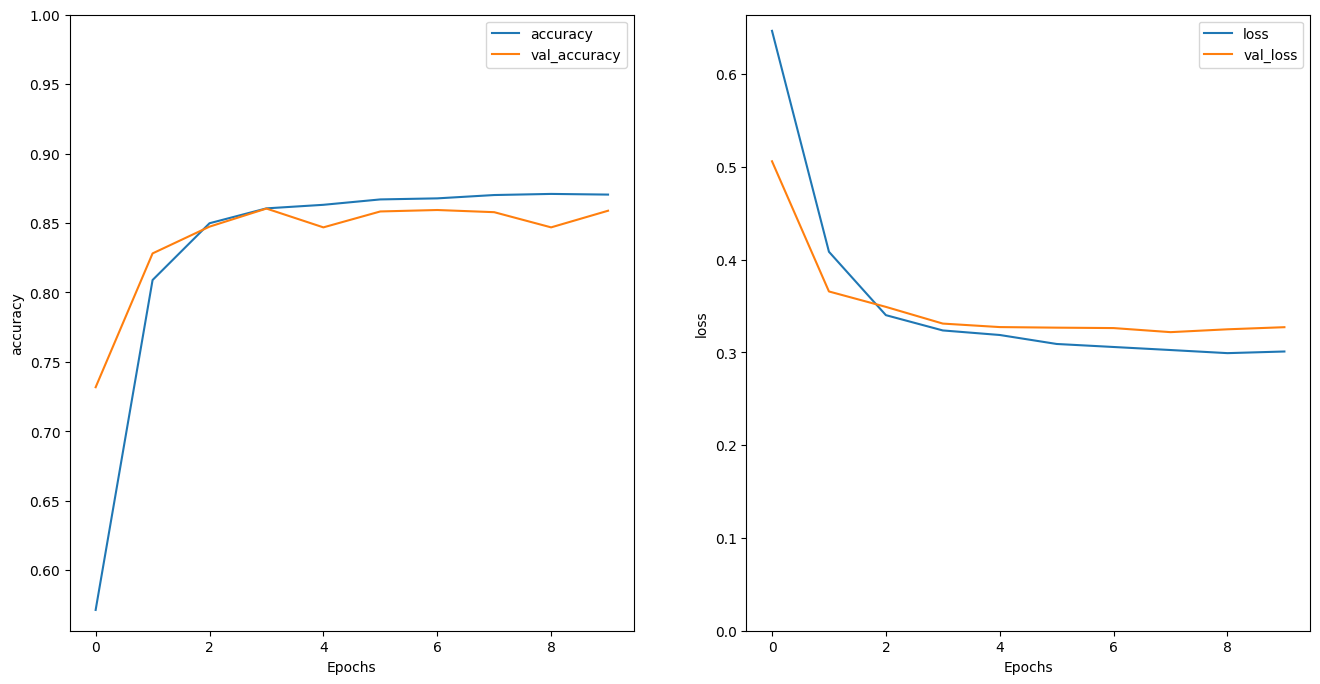

In [17]:
plt.figure(figsize=(16, 8)) # Membuat figure dengan ukuran 16 x 8
plt.subplot(1, 2, 1) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 1
plot_graphs(history, 'accuracy') # memplot grafik akurasi dari objek History
plt.ylim(None, 1) # mengatur batas y dari grafik akurasi agar dimulai dari 0 dan berakhir di 1
plt.subplot(1, 2, 2) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 2
plot_graphs(history, 'loss') # memplot grafik loss dari objek History
plt.ylim(0, None) #  mengatur batas y dari grafik loss agar dimulai dari 0

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.') # Inisialisasi variabel sample_text

predictions = model.predict(np.array([sample_text])) # Melakukan prediksi nilai berdasarkan sample_text yang dirubah ke array numpy

1/1 [==============================] - 3s 3s/step


In [19]:
model = tf.keras.Sequential([ # Membual model Sequential
    encoder, # Variabel encoder sebelumnya sebagai parameter
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), # Membuat embeded layer dengan jumlah token dalam vocabulary dan 64 banyak fitur yang mewakili token serta Mengabaikan token dengan indeks 0
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # Membuat layer bidirectional dengan layer LTSM 64 unit dan mengembalikan seluruh urutan output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # # Membuat layer bidirectional dengan layer LTSM 32 unit
    tf.keras.layers.Dense(64, activation='relu'), # Menambhakan layer Dense (Fully-Connected) dengan 64 neuron dan fungsi aktivasi berupa ReLU
    tf.keras.layers.Dropout(0.5), # enonaktifkan 50% dari unit di lapisan sebelumnya secara acak pada setiap iterasi pelatihan
    tf.keras.layers.Dense(1) # Menambhakan layer Dense (Fully-Connected) dengan 1 neuron
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Compile Model dengan argument loss berdasarkan BinaryCrossentropy dengan output logits (nilai numerik yang mewakili kemungkinan kelas 1 dan 0)
            optimizer=tf.keras.optimizers.Adam(1e-4), # Menggunakan optimizer ADAM dengan learning rate 1e-4
            metrics=['accuracy']) # Dan argument metrics dengan accuracy

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30) # Melatih model dengan train_dataset dan 10 epoch serta 30 sampel validasi

Epoch 1/10
391/391 [==============================] - 1510s 4s/step - loss: 0.6394 - accuracy: 0.5752 - val_loss: 0.4377 - val_accuracy: 0.7964
Epoch 2/10
 74/391 [====>.........................] - ETA: 18:38 - loss: 0.4271 - accuracy: 0.8036

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset) # Menyimpan nilai loss dan accuracy hasil dari evaluasi model dengan test_dataset

print('Test Loss:', test_loss) # Menampilkan nilai variabel test_loss
print('Test Accuracy:', test_acc) # Menampilkan nilai variabel test_acc

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.') # Inisialisasi variabel sample_text

predictions = model.predict(np.array([sample_text])) # Melakukan prediksi nilai berdasarkan sample_text yang dirubah ke array numpy
print(predictions) # Menampilkan nilai prediksi

In [ ]:
plt.figure(figsize=(16, 6)) # Membuat figure dengan ukuran 16 x 6
plt.subplot(1, 2, 1) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 1
plot_graphs(history, 'accuracy') # memplot grafik akurasi dari objek History
plt.subplot(1, 2, 2) # membuat subplot dengan 1 baris dan 2 kolom, dan subplot ini akan ditempatkan di indeks 2
plot_graphs(history, 'loss') # memplot grafik loss dari objek History